In [14]:
import matplotlib.pyplot as plt
import glob
from radar import RadarMesure
from scipy.signal import find_peaks
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from scipy.optimize import curve_fit

c = 299792458
lambdaa = c/(17.5e9)
sigmacr13 = (np.pi*4*0.3302**4)/(3*lambdaa**2)


def bin_to_dist(x,pad_factor=1):
    c = 299792458
    B = 2e9   #bandwith
    ramptime = 102400e-9
    frequence_echantillonage = 10e6 
    rangebinresolution = frequence_echantillonage/1024              #DF
    fb = x*rangebinresolution
    dist = fb*c*ramptime/(2*B)
    dist=dist/pad_factor
    return(dist)

    
# Chemin vers le fichier
data = glob.glob('/home/nicolas/Documents/Dku-toolbox/data/newcod/17GHz_erk*.txt')
data.sort()
# Création de l'instance
ri = []
[ri.append(RadarMesure(i,beta = 8, pad_factor = 5)) for i in data]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [15]:
def func(R, c):
    return np.sqrt(c * sigmacr13 / (R**4))
print(ri[0].numero)

10


/tmp/ipykernel_31687/2368552814.py:2: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(c * sigmacr13 / (R**4))


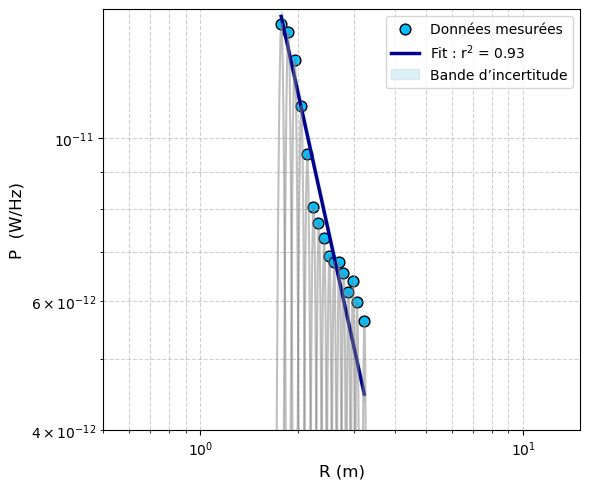

In [26]:
pic = []

for i in ri :
    df = i.df
    peaks,prop = find_peaks(df.copol.loc[0.4:5],height=1e-6)
    if len(peaks) != 0 :
        pic.append((bin_to_dist(peaks[0],5)+0.4,prop['peak_heights'][0]**2))
#    plt.plot(df.index,df.copol,label = i.numero)

#plt.xlim(0,4)
#plt.legend()
#plt.show()

dfpic = pd.DataFrame(pic).sort_values(by=[0]) 
df_corrigé=dfpic

X= np.asarray(df_corrigé[0])
y = np.asarray(df_corrigé[1])

popt, pcov = curve_fit(func, X, y)

y_pred = func(X, *popt)
r2 = r2_score(y, y_pred)

# Préparation du fit
x_fit = np.linspace(X.min(), X.max(), 300)
y_fit = (func(x_fit, *popt))

# Erreur sur le paramètre c
perr = np.sqrt(np.diag(pcov))
c_err = perr[0]

# Calcul de r2 
r2 = r2_score(y,func(X, *popt))

# Calcul bande d'incertitude
y_fit_upper = (func(x_fit, *(popt[0] + c_err,)))
y_fit_lower = (func(x_fit, *(popt[0] - c_err,)))





# Visualisation du fit calibration avec |S(t)| en y et distance R en x
fig, ax = plt.subplots(figsize=(6, 5))

#for i in ri :
#    df = i.df
#    ax.plot(df.index,df['copol']**2,color = 'grey', alpha = 0.5)


# Scatter des points mesurés
ax.scatter(X, y, s=60, facecolors='deepskyblue', edgecolors='black', label='Données mesurées')


# Tracer la courbe de fit
ax.plot(x_fit, y_fit, color='darkblue', linewidth=2.5, label=f'Fit : r$^2$ = {r2 :.2f}')

# Tracer la bande d’incertitude
ax.fill_between(x_fit, y_fit_lower, y_fit_upper, color='lightblue', alpha=0.4, label='Bande d’incertitude')



for i in ri :
    df = i.df

    ax.plot(df.index,df['copol']**2,color = 'grey', alpha = 0.5)

# Titres et labels
ax.set_xlabel("R (m)", fontsize=12)
ax.set_ylabel(r"P  (W/Hz)", fontsize=12)
#ax.set_title("before_realignment-13", fontsize=14)
ax.set_xlim(.5 ,15)
ax.set_ylim(.4e-11,1.5e-11)
ax.set_yscale('log')
ax.set_xscale('log')

# Grille et légende
ax.grid(True, which='both', linestyle='--', alpha=0.6)
ax.legend(fontsize=10)

# Layout propre
plt.tight_layout()
# plt.savefig('../fig/before_realignment-13.png')
plt.show()